In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cwd = os.getcwd()
lib_dir = os.path.join(os.path.dirname(cwd), "lib")
sys.path.append(lib_dir)

DATASET = "FSD50K.eval_audio"
data_dir = os.path.join(os.path.dirname(os.path.dirname(cwd)), "data")
eval_dir = os.path.join(data_dir, "evaluation_results", DATASET)
figures_dir = os.path.join(data_dir, "figures")

from plot import *
from evaluate import *

## Compare New and Old Metrics

In [2]:
data_dir = "../data/"

old_eval_dir = os.path.join(data_dir, "evaluation_results_", "FSD50K.eval_audio")
new_eval_dir = os.path.join(data_dir, "evaluation_results", "FSD50K.eval_audio")

old_models = sorted(os.listdir(old_eval_dir))
new_models = sorted(os.listdir(new_eval_dir))

FileNotFoundError: [Errno 2] No such file or directory: '../data/evaluation_results_/FSD50K.eval_audio'

In [41]:
search = "dot"

old_model = old_models[24]
print(old_model)

old_path = os.path.join(old_eval_dir, old_model, search, "mAP.csv")
new_path = os.path.join(new_eval_dir, old_model, search, "mAP.csv")

old_df = pd.read_csv(old_path)
new_df = pd.read_csv(new_path)

old_df["old_mAP"] = old_df["mAP"]
old_df.drop(columns=["mAP"], inplace=True)
old_df["new_mAP"] = new_df["mAP"]

print(old_df)

audioset-yamnet-1-Agg_mean-PCA_100-Norm_False
    k   old_mAP   new_mAP
0  15  0.592810  0.578244
1  30  0.565908  0.556233
2  45  0.550928  0.543340
3  60  0.539486  0.531803
4  75  0.531022  0.524058
5  90  0.524287  0.517497


## Load An Embedding's Results

In [42]:
embedding_name = "audioset-vggish-3-Agg_max-PCA_64-Norm_True"
search_name = "dot"
results_path = f"../data/similarity_results/FSD50K.eval_audio/{embedding_name}/{search_name}/similarity_results.json"

results_dict = {}
with open(results_path, "r") as infile:
    for jline in infile:
        result = json.loads(jline)
        results_dict[result["query_fname"]] = result["results"]
fnames = list(results_dict.keys())

## Micro and Macro AP

In [46]:
label_based_map_at_15 = label_based_map(results_dict, df, k=15)
# Calculate the mean label-based mAP@15
av_label_based_map_at_15 = sum(map(lambda x: x["mAP"], label_based_map_at_15))/len(label_based_map_at_15)

In [47]:
av_label_based_map_at_15

0.7037802473652355

In [5]:
label_maps = label_based_map(results_dict, df, k=15)

In [7]:
label_maps = pd.DataFrame(label_maps)

In [8]:
label_maps

,label,map
0,Crash_cymbal,0.990452
1,Accordion,0.957533
2,Strum,0.953759
3,Acoustic_guitar,0.948948
4,Harmonica,0.946688
...,...,...
195,Tick,0.356989
196,Shatter,0.354463
197,Camera,0.337624
198,Crushing,0.308644


In [81]:
k = 15

label_maps = []
for label in labels:
    fnames_with_label = df[df["labels"].apply(lambda x: label in x)].fname.to_list()
    aps = [] # ap values for this fname
    for query_fname in fnames_with_label:
        result = results_dict[str(query_fname)][:k] # Cutoff at k
        ap = calculate_average_precision(query_fname, result, df)
        aps.append(ap)
    map = sum(aps)/len(aps) # mean average precision @k
    label_maps.append((label, map))
label_maps = sorted(label_maps, key=lambda x: x[1], reverse=True)

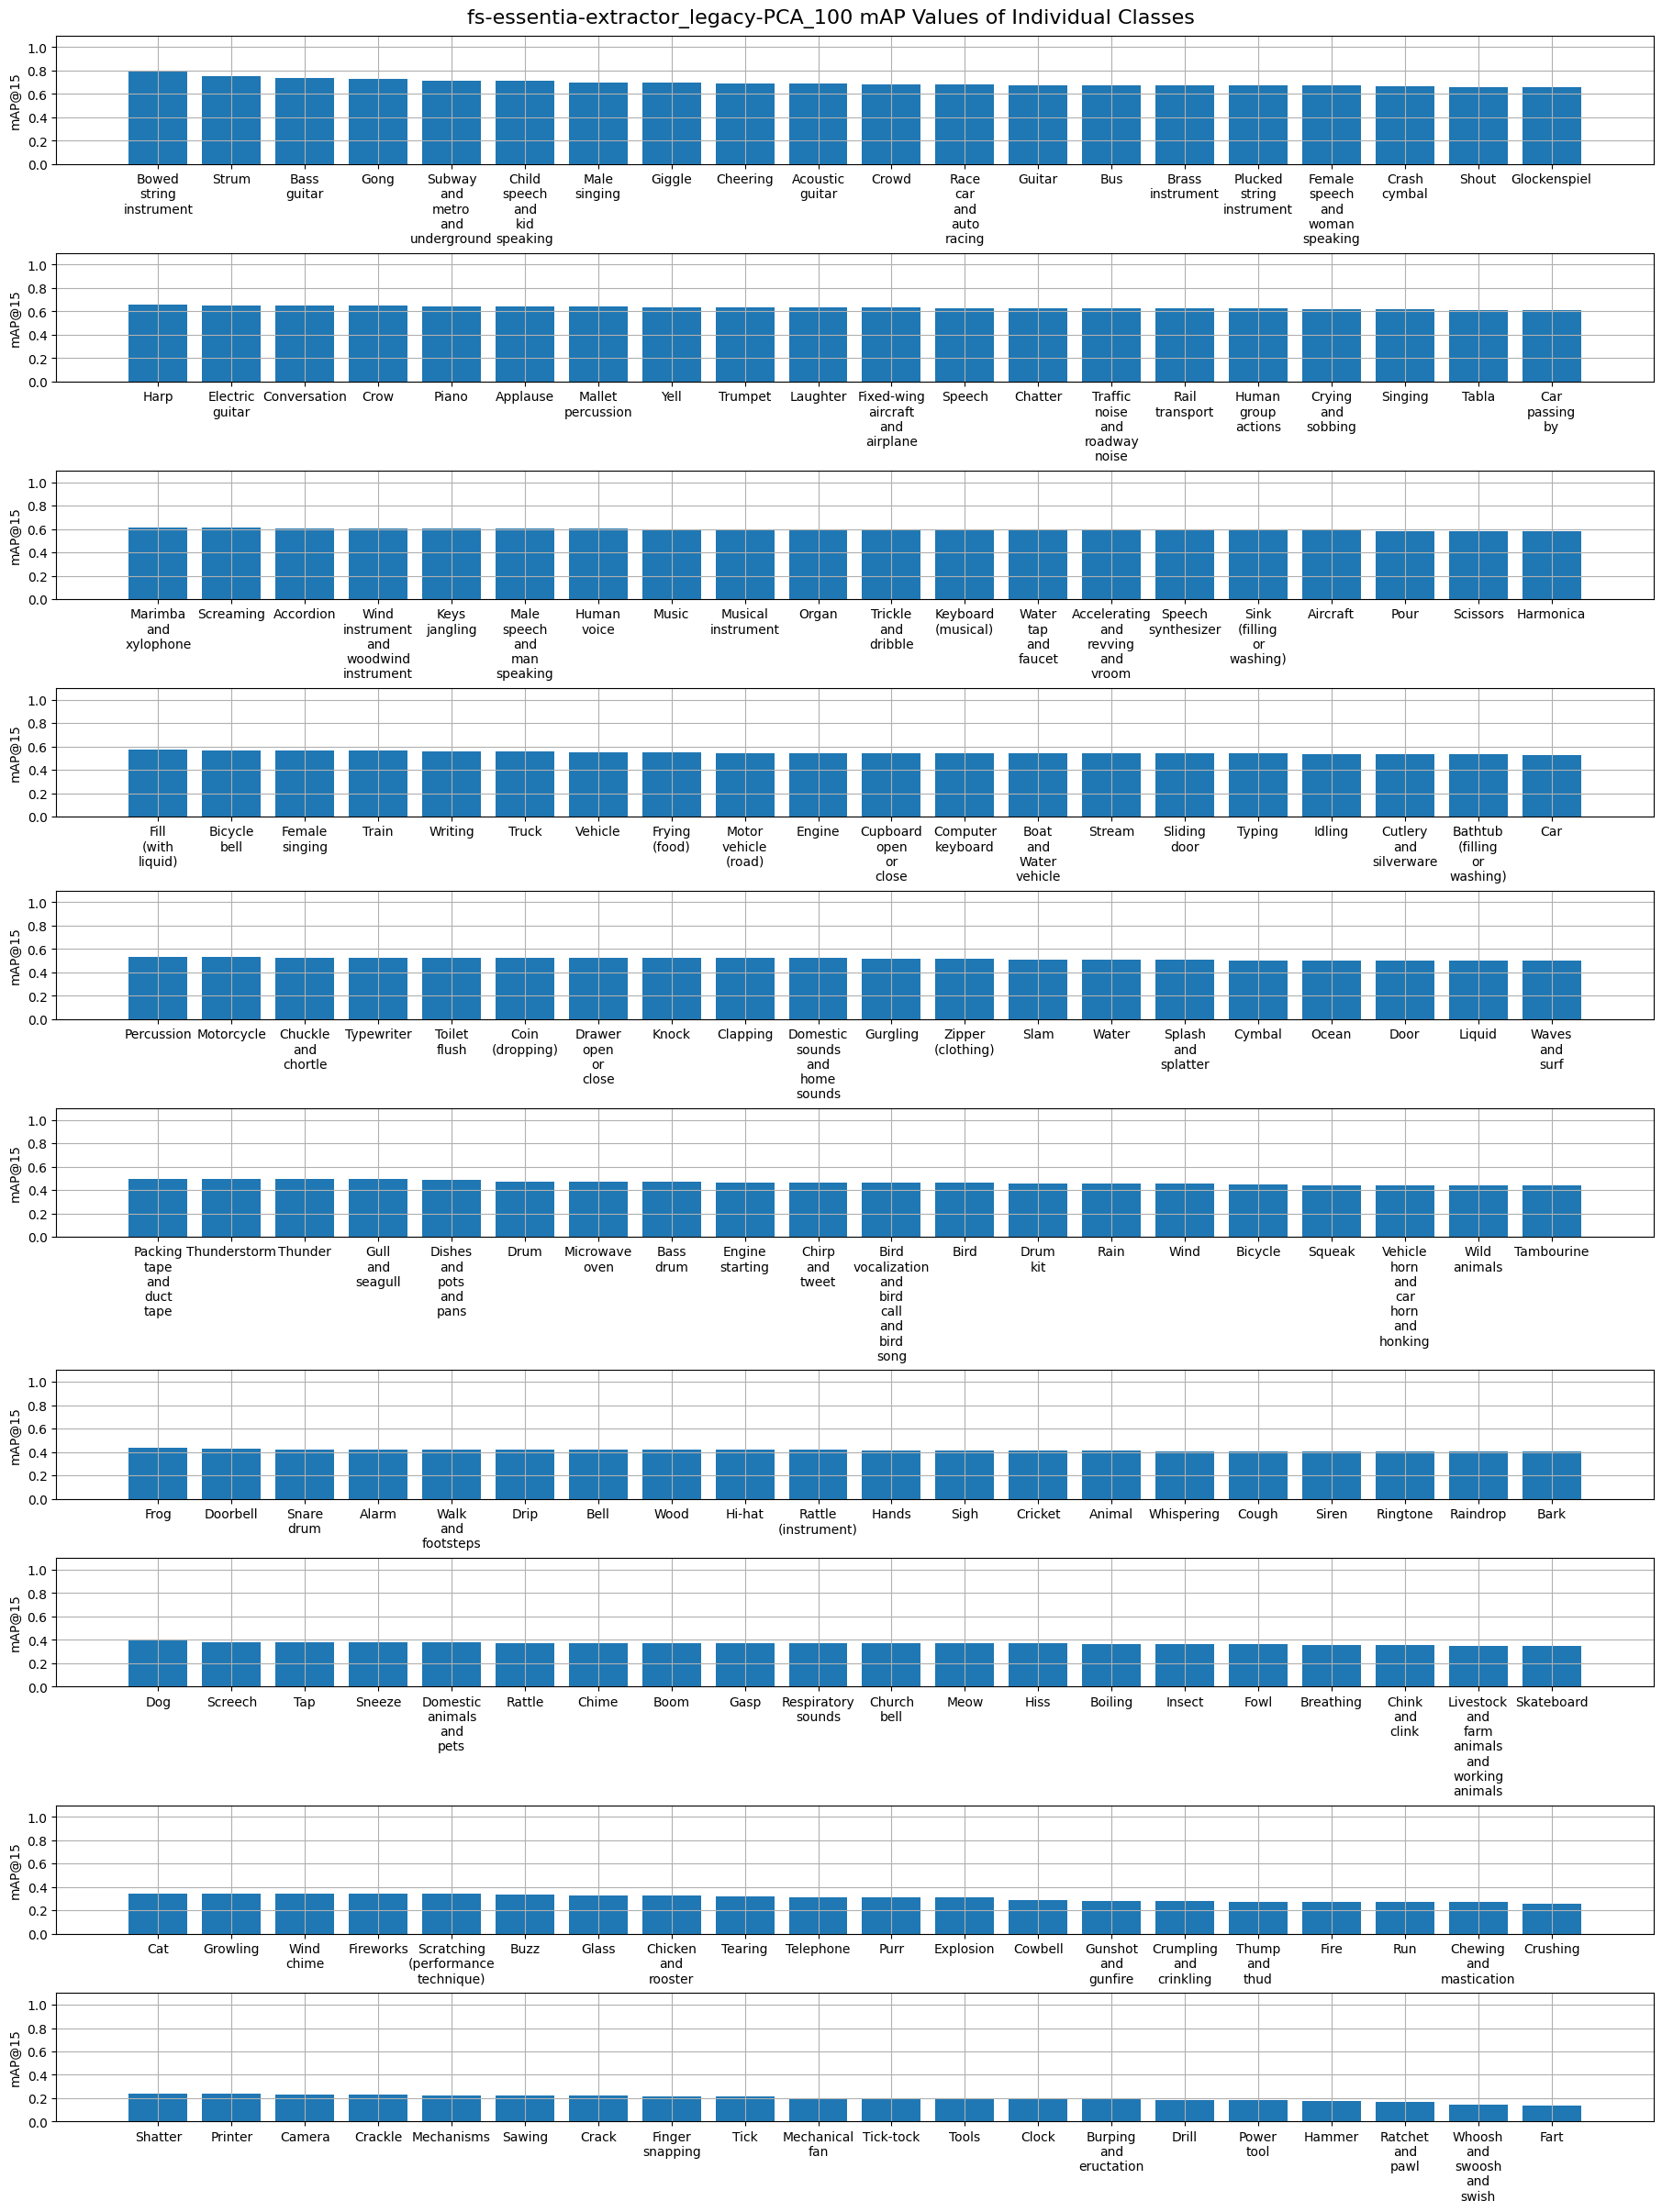

In [79]:
N = 10
delta = len(label_maps) // N
fig, ax = plt.subplots(figsize=(18, 24), nrows=N, constrained_layout=True)
fig.suptitle(f"{embedding_name} mAP Values of Individual Classes", fontsize=16)
for i in range(N):
    ax[i].bar([label.replace("_","\n") for label,_ in label_maps[i*delta:(i+1)*delta]], 
              [count for _, count in label_maps[i*delta:(i+1)*delta]])
    ax[i].set_yticks(np.arange(0, 1.1, 0.2))
    ax[i].grid()
    ax[i].set_ylim([0, 1.1])
    ax[i].set_ylabel("mAP@{}".format(k))
plt.show()

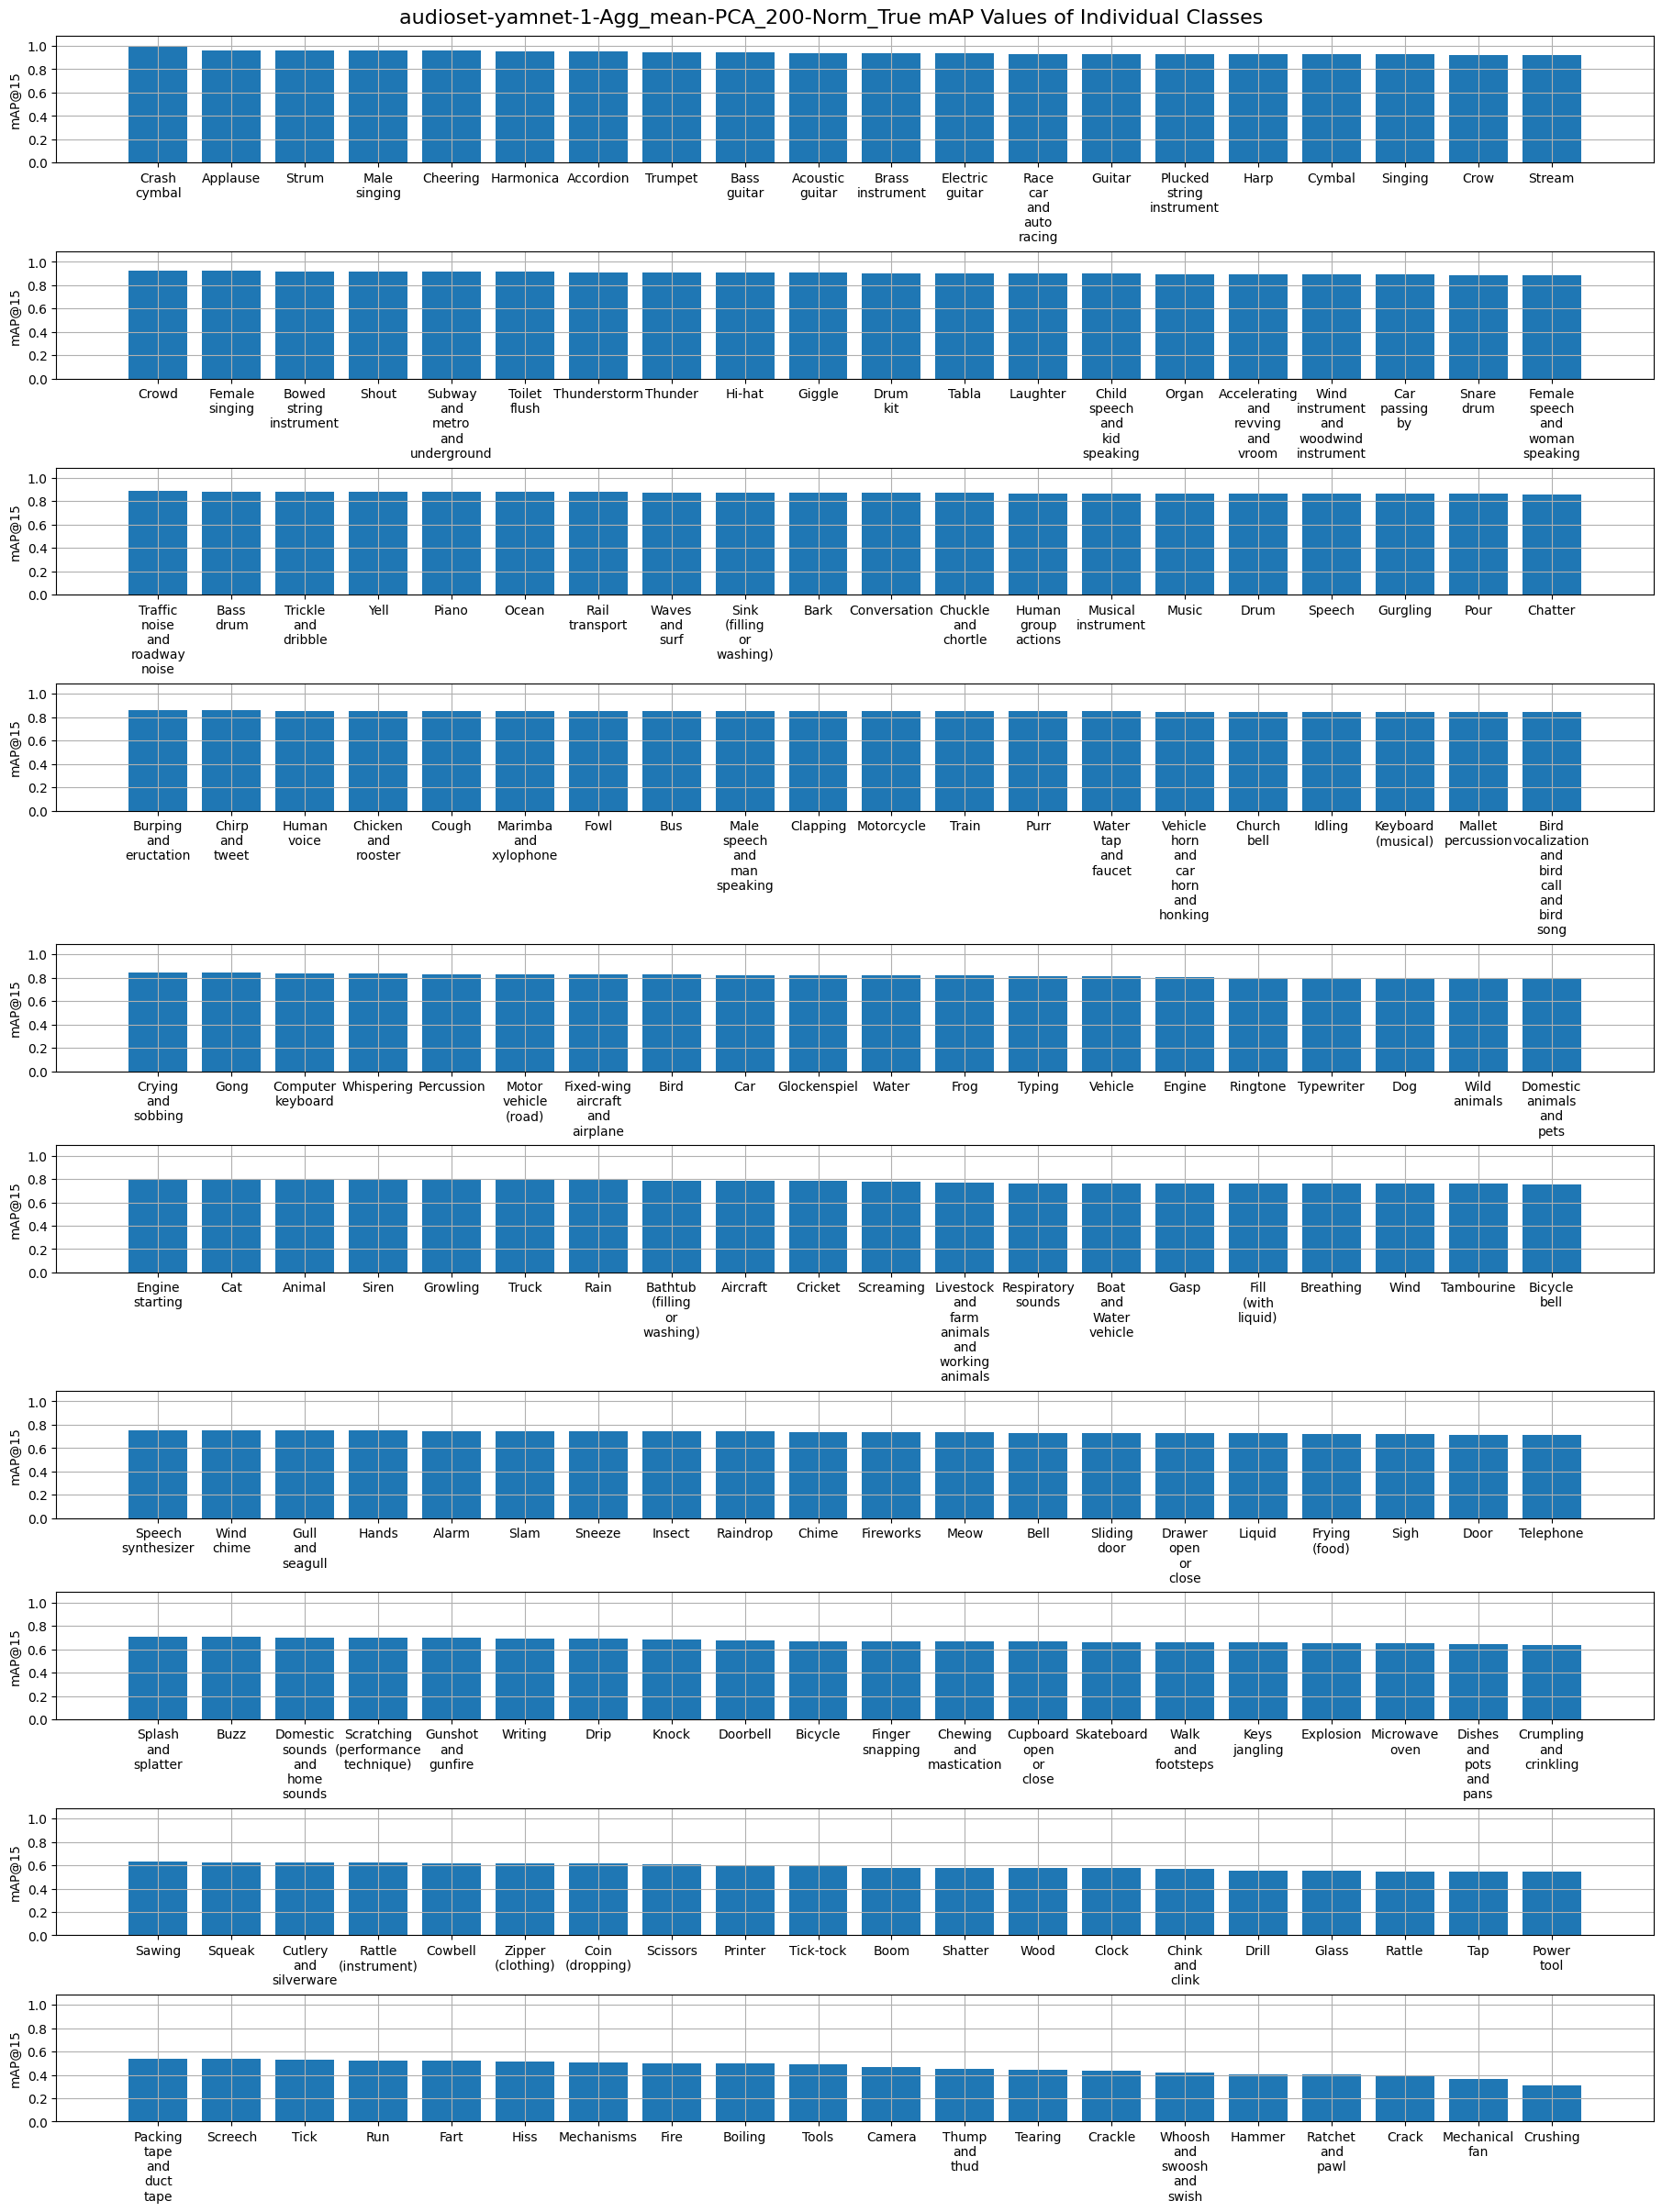

In [82]:
N = 10
delta = len(label_maps) // N
fig, ax = plt.subplots(figsize=(18, 24), nrows=N, constrained_layout=True)
fig.suptitle(f"{embedding_name} mAP Values of Individual Classes", fontsize=16)
for i in range(N):
    ax[i].bar([label.replace("_","\n") for label,_ in label_maps[i*delta:(i+1)*delta]], 
              [count for _, count in label_maps[i*delta:(i+1)*delta]])
    ax[i].set_yticks(np.arange(0, label_maps[0][1]+0.1, 0.2))
    ax[i].grid()
    ax[i].set_ylim([0, label_maps[0][1]+0.1])
    ax[i].set_ylabel("mAP@{}".format(k))
plt.show()

## Self-implementation

In [3]:
def prec_k(y_true, k):
    # k is an index
    return sum(y_true[:k+1])/(k+1)

def calculate_average_precision_2(query_fname, result, df):
    result = results_dict[query_fname]
    query_labels = get_labels(query_fname, df)
    # Evaluate if each document is relevant
    relevance = []
    for ref_result in result:
        ref_fname = ref_result["file_name"]
        ref_labels = get_labels(ref_fname, df)
        # Find if a retrieved document is relevant
        if len(query_labels.intersection(ref_labels)) > 0:
            relevance.append(1)
        else:
            relevance.append(0)
    # Calculate the average prediction
    return ap(relevance)

def ap(relevance):
    # Calculate the average prediction
    total_relevant = sum(relevance) # Number of relevant documents
    if total_relevant==0:
        return 0
    else:
        # Calculate prec@k values
        return sum([rel_k*prec_k(relevance,k) for k,rel_k in enumerate(relevance)]) / total_relevant

In [19]:
for query_fname in fnames:
    result = results_dict[query_fname]
    A = calculate_average_precision(query_fname, result, df)
    B = calculate_average_precision_2(query_fname, result, df)
    if np.abs(A-B)>0.0001:
        print(np.abs(A-B))
        print(query_fname)

0.003409090909090917
367181
0.0006893382352942679
400391
0.00035256410256423454
117645
0.0076923076923077205
409233
0.0009408602150537404
34979


In [15]:
def test_ap():

    results = [
            [1,1,0,0,0,0], 
            [0,0,0,0,1,1], 
            [0,1,0,1,0,0], 
            ]
    
    aps = [
        1.0,
        0.266,
        0.5,
    ]
    
    for i,result in enumerate(results):
        delta = ap(result)-aps[i]
        if abs(delta)>0.001:
            print("Error")

In [16]:
test_ap()

In [52]:
query_fname = fnames[10]
result = results_dict[query_fname]
ap, _ = calculate_average_precision(query_fname, result, df)
print(ap)

0.925017849483906


In [ ]:
aps = []
for query_fname in fnames:
    result = results_dict[query_fname]
    ap, _ = calculate_average_precision(query_fname, result, df)
    aps.append(ap)
map = sum(aps)/len(aps)
print(map)
    

In [8]:
import os
lol = "/home/roguz/freesound-perceptual_similarity/similarity_results/audioset-yamnet_v1/eval/dot-mean-results.json"
dataset_name = os.path.basename(os.path.dirname(lol))
model_name = os.path.basename(os.path.dirname(os.path.dirname(lol)))
output_dir = os.path.join("lololo", model_name,dataset_name)
#os.makedirs(output_dir, exist_ok=True)
print(f"Results are exported to {output_dir}")
results_name = os.path.splitext(os.path.basename(lol))[0]
os.path.join(output_dir, f"{results_name}.csv")

Results are exported to lololo/audioset-yamnet_v1/eval


'lololo/audioset-yamnet_v1/eval/dot-mean-results.csv'



query_fname = fnames[6]
query_labels = set(get_labels(query_fname, df))

result = results_dict[query_fname]

y_true, y_score, counts = [], [], []
for ref_result in result:
    ref_fname = list(ref_result.keys())[0]
    ref_score = list(ref_result.values())[0]
    y_score.append(ref_score)
    ref_labels = set(get_labels(ref_fname, df))
    counter = query_labels.intersection(ref_labels)
    counts.append(len(counter))
    if len(counter) > 0:
        y_true.append(1)
    else:
        y_true.append(0)
print(y_score)
print(y_true)
print(counts)

print(average_precision_score(y_true, y_score))

In [ ]:
query_fname = fnames[6]
query_labels = set(get_labels(query_fname, df))

result = results_dict[query_fname]
print(query_labels)
for ref_result in result:
    ref_fname = list(ref_result.keys())[0]
    print(set(get_labels(ref_fname, df)))

/home/roguz/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


-0.0

In [13]:
for _ in range(100):
    i,j = np.random.randint(0,len(df),size=(2,))

    query = df.iloc[i]
    query_labels = query.labels.split(",")

    ref = df.iloc[j]
    ref_labels = ref.labels.split(",")

    counter = 0
    for r_label in ref_labels:
        if r_label in query_labels:
            counter +=1
    print(counter)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
1
0
0
0
1
0
0
0
2
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
1
1
0
0
0
0
0
0
3
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
0
0
2
0
0
0
0


['Male_speech_and_man_speaking', 'Speech', 'Human_voice']